# Interconnect Client Churn

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts. We will analyze the data, and train a model to forecast if a client is going to stay or leave based on client data.

## Table of Contents


1. General Information
    1. Data Preparation
2. Data Preprocessing
3. Exploratory Data Analysis (EDA)
4. Model Training
5. Conclusion

## General Information

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer


Load the packages/modules needed

In [41]:
#import all of the data sets

contract  = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [42]:
#Examine the data sets

contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


A couple of things are wrong for this file:

- **'BeginDate'** and **'EndDate'** needs to be changed to datetime type. 
- **'Type'**, **'PaperlessBilling'**, and **'PaymentMethods'** should be category type.
- **'TotalCharges'** needs to be changed to float type.

In [43]:
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


For this file:

- **'Gender'**, **'SeniorCitizen'**, **'Partner'**, and **'Depdendents'** will need to be changed to categorical datatype. 

In [44]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


The total number of rows are less compared to the personal information dataset, suggesting that not all customers have subscribe to the internet service. 

- **'InternetService'**, **'OnlineSecurity'**, **'OnlineBackup'**, **'DeviceProtection'**, **'TechSupport'**, **'StreamingTV'** and **'StreamingMovies'** will need to be changed to categorical datatype. 

In [45]:
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


The total number of rows are less compared to the personal information dataset, suggesting that not all customers have subscribe to the phone service. 

- **'MultipleLines'** needs to be changed to categorical datatype. 


We have examined all of the datasets needed to build/train our model. We will determine values to use for features and target. 

**Target**: in this case, we will need to create a new column named **'churn'**, it will be based on **'EndDate'** column from contract dataset. If the value is 'NO' it will be assigned with a value 0, indicating the customer has not left. If there is an end date, then it will be assigned with a value 1, indicating the customer has terminated their contract. 

**Features**: 
- from contract dataset: `'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges'`
- from personal dataset: `'gender', 'SeniorCitizen', 'Partner', 'Dependents'`
- from internet dataset: `'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection ', 'TechSupport', 'StreamingTV', 'StreamingMovies'`
- from phone dataset : `'MultipleLines'`

we can also create a feature column that will contain the duration of the customer's stay with the company by using 'StartDate' and 'EndDate'. It can be in months or days. 

**Clarifying Questions**

1. Is there a certain time period of churn rate that we are evaluating? Should it be based on 'months', 'days', 'weeks', or 'years'.
2. What is our primary metric, what metric are we using to determine the efficiency/accuracy of the model?
3. Is there other metric that we will need?
4. What is our threshold for metric? 
5. Is there a test dataset?

**Steps**

1. Data Preprocessing

in this step, we will convert necessary columns to their correct datatype. We will then create a new column for our target variables, and possibly a feature column. We will also need to merge the separate datasets into one where it will contain all of our feature columns and target column. 

2. Data Analysis

We will check for features to determine if there are any outliers, null values, or class imbalance that might interfere with our model training.

3. Model Training

After preprocessing and analysis. We can then start building/training our machine learning model. First by Upsampling/downsampling based on the class imbalance results. Then we will encode and scale the data, and compare the metrics of sets after encoding to the one without encoiding/scaling. We will split the sample into training and validation set, with a 3:1 ratio or depending on the existence of test dataset, it might be a 3:1:1 split with training, validation and test set if a test set does not exist. Test different hyperparameters, use cross-validation to test. Finally, we will employ different models to search for the best result. 

4. Conclusion

Lastly, we will analyze and compare the models cross validation scores, and apply to the model to our test set to obtain the final result. 


## Data Preprocessing

We will first start with our 'contract' dataset. As mentioned above, 'BeginDate' and 'EndDate' needs to be changed to datetime type. 
'Type', 'PaperlessBilling', and 'PaymentMethods' should be category type. 
And 'TotalCharges' needs to be changed to float type.

We will also create a column called **'Churn'**, it will be used as our target.
We will create a feature column that contains the duration of the stay, for Enddate = No, we will replace it with the day the dataset was extracted from: 2020-02-01.

In [46]:
#datatype conversion

contract['Type'] = contract['Type'].astype('category')
contract['PaperlessBilling'] = contract['PaperlessBilling'].astype('category')
contract['PaymentMethod'] = contract['PaymentMethod'].astype('category')
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors = 'coerce')
contract['churn'] = (contract['EndDate'] != 'No').astype('int')
contract['EndDate'] = contract['EndDate'].replace('No', '2020-02-01 00:00:00')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format = '%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
contract['totaldays'] = (contract['EndDate'] - contract['BeginDate']).dt.days
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   churn             7043 non-null   int64         
 9   totaldays         7043 non-null   int64         
dtypes: category(3), datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 406.4+ KB


Now we will drop the columns that we no longer need. only saving the ones we need for merging the tables and use as features later on. 

In [47]:
#dropping columns & rows in total charge that are NaN

contract_new = contract.drop(['BeginDate', 'EndDate'], axis = 1)
contract_new = contract_new.dropna(subset=['TotalCharges'])

contract_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   Type              7032 non-null   category
 2   PaperlessBilling  7032 non-null   category
 3   PaymentMethod     7032 non-null   category
 4   MonthlyCharges    7032 non-null   float64 
 5   TotalCharges      7032 non-null   float64 
 6   churn             7032 non-null   int64   
 7   totaldays         7032 non-null   int64   
dtypes: category(3), float64(2), int64(2), object(1)
memory usage: 350.7+ KB


For the personal file, 'Gender', 'SeniorCitizen', 'Partner', and 'Depdendents' will need to be changed to categorical datatype.

In [48]:
#datatype conversion

personal['gender'] = personal['gender'].astype('category')
personal['Partner'] = personal['Partner'].astype("category")
personal['Dependents'] = personal['Dependents'].astype("category")
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype("category")

personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerID     7043 non-null   object  
 1   gender         7043 non-null   category
 2   SeniorCitizen  7043 non-null   category
 3   Partner        7043 non-null   category
 4   Dependents     7043 non-null   category
dtypes: category(4), object(1)
memory usage: 83.1+ KB


Now we can merge personal and contract together by customer ID. 

In [49]:
#Merge contract and personal

personal_contract = pd.merge(personal, contract_new, how = 'left', on = 'customerID')
personal_contract.info()
personal_contract.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  churn             7032 non-null   float64 
 11  totaldays         7032 non-null   float64 
dtypes: category(7), float64(4), object(1)
memory usage: 379.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,totaldays
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31.0
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0.0,1036.0
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61.0
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371.0
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61.0


Since we can't really fill those missing values, we will just drop them. 

In [50]:
#drop NAs

personal_contract.dropna(inplace = True)
personal_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  churn             7032 non-null   float64 
 11  totaldays         7032 non-null   float64 
dtypes: category(7), float64(4), object(1)
memory usage: 378.6+ KB


For Phone and Internet datasets. We will merge them first before converting datatypes, since it will likely result in missing values. 

In [51]:
#merging personal_contract with phone

personal_contract_phone = pd.merge(personal_contract, phone, how = 'left', on = 'customerID')
personal_contract_phone.info()
personal_contract_phone.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  churn             7032 non-null   float64 
 11  totaldays         7032 non-null   float64 
 12  MultipleLines     6352 non-null   object  
dtypes: category(7), float64(4), object(2)
memory usage: 433.6+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,totaldays,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31.0,NaN
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0.0,1036.0,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61.0,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371.0,NaN
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61.0,No


Now we do the final merge.

In [52]:
client_data = pd.merge(personal_contract_phone, internet, how = 'left', on = 'customerID')
client_data.info()
client_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  churn             7032 non-null   float64 
 11  totaldays         7032 non-null   float64 
 12  MultipleLines     6352 non-null   object  
 13  InternetService   5512 non-null   object  
 14  OnlineSecurity    5512 non-null   object  
 15  OnlineBackup      5512 non-null   object  
 16  DeviceProtection  5512 n

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,totaldays,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31.0,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0.0,1036.0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61.0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371.0,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61.0,No,Fiber optic,No,No,No,No,No,No


Convert 'Churn' back to integer. and replace missing values. By examining the dataset we noticed that when users have missing values in their rows, it indicates that they did not subscribe to that service. Therefore, we can simiply fill the missing values with 'No'. 

In [53]:
#convert & fill

client_data['churn'] = client_data['churn'].astype('int')

columns = client_data.columns[client_data.dtypes == 'object']
client_data[columns] = client_data[columns].fillna('No')
client_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  churn             7032 non-null   int64   
 11  totaldays         7032 non-null   float64 
 12  MultipleLines     7032 non-null   object  
 13  InternetService   7032 non-null   object  
 14  OnlineSecurity    7032 non-null   object  
 15  OnlineBackup      7032 non-null   object  
 16  DeviceProtection  7032 n

In [54]:
#convert those newly added object type columns to category

client_data['OnlineSecurity'] = client_data['OnlineSecurity'].astype("category")
client_data['OnlineBackup'] = client_data['OnlineBackup'].astype("category")
client_data['TechSupport'] = client_data['TechSupport'].astype("category")
client_data['DeviceProtection'] = client_data['DeviceProtection'].astype("category")
client_data['StreamingTV'] = client_data['StreamingTV'].astype("category")
client_data['StreamingMovies'] = client_data['StreamingMovies'].astype("category")
client_data['InternetService'] = client_data['InternetService'].astype('category')
client_data['MultipleLines'] = client_data['MultipleLines'].astype("category")

client_data.info()
client_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  churn             7032 non-null   int64   
 11  totaldays         7032 non-null   float64 
 12  MultipleLines     7032 non-null   category
 13  InternetService   7032 non-null   category
 14  OnlineSecurity    7032 non-null   category
 15  OnlineBackup      7032 non-null   category
 16  DeviceProtection  7032 n

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,totaldays,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,31.0,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0,1036.0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,61.0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371.0,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,61.0,No,Fiber optic,No,No,No,No,No,No


Let's move on Exploratory Data Analysis.

## Exploratory Data Analysis (EDA)

### Class Imbalance

We will first look at the class imbalance in our target column 'churn'. 

In [55]:
#class imblance

client_data['churn'].value_counts()

0    5163
1    1869
Name: churn, dtype: int64

We see that there is clearly a class imbalance in our dataset. 5163 clients still has service, whereas 1869 people have stopped the services. 

### Graphical Representation of Features vs Target

Let's see the graphical representation of how churn is distributed grouping with features. 

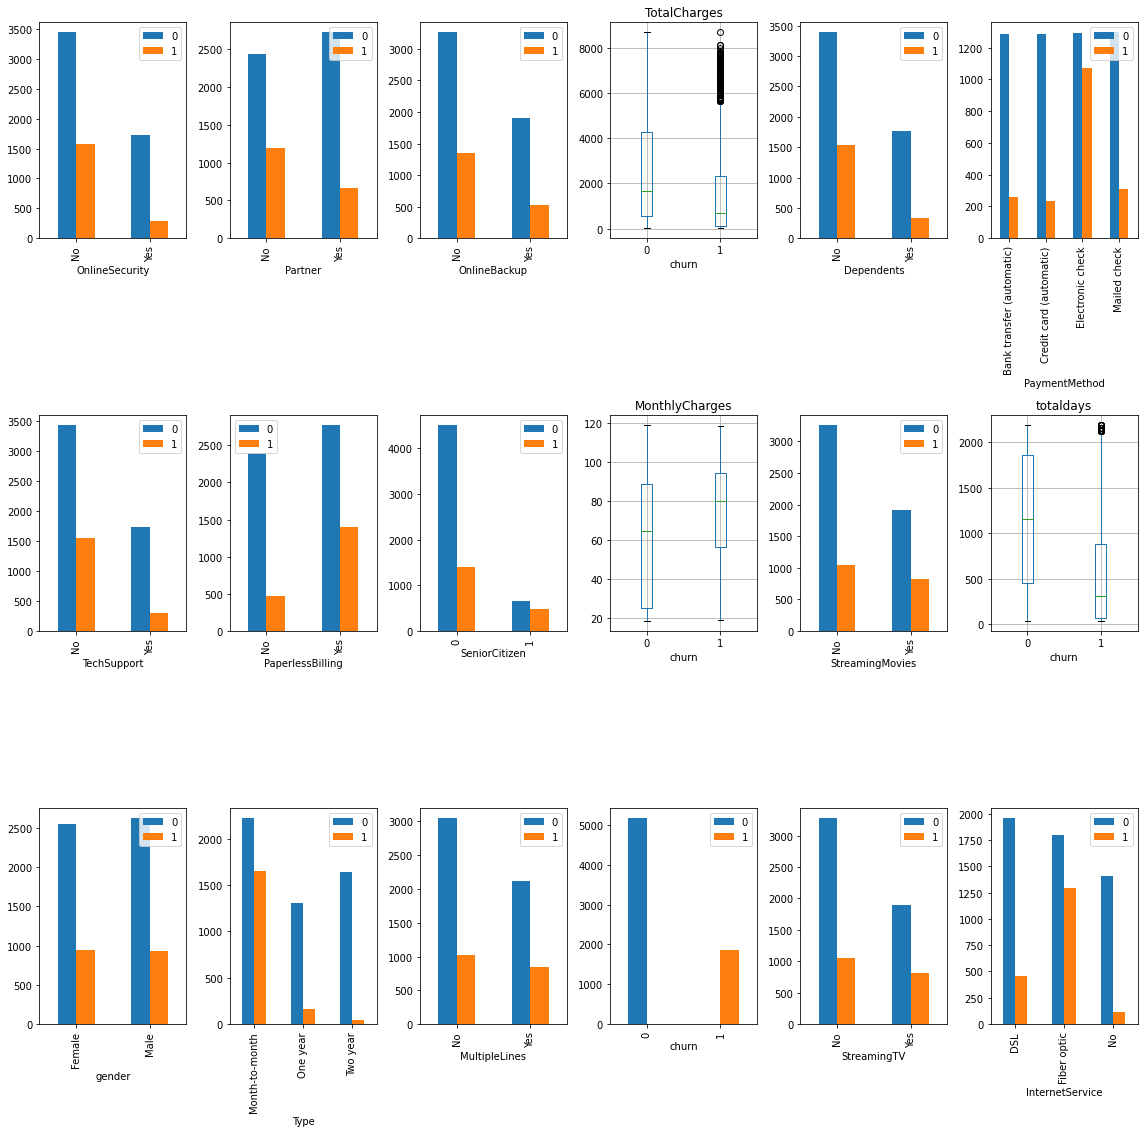

In [56]:
#plot graphs with features vs churn. We will use bar charts for categorical values, and boxplot for discrete features.

fig, axs = plt.subplots(3, len(client_data.columns) // 3, figsize = (16, 16))
axs = axs.flatten()
cols = list(set(client_data.columns) - set(['customerID']))
for col, ax in zip(cols, axs):
    if client_data[col].dtype == 'float64':
        client_data.boxplot(column = col, by='churn', ax = ax)
        plt.suptitle('')
    else:
        data = client_data.groupby([col, 'churn'])['churn'].count().unstack()
        data.plot(kind = 'bar', stacked = False, label = 'churn', ax = ax)
        ax.legend()        
plt.tight_layout()
plt.show()

From the graphs, we see that the customers that have left are highly enriched in the ones that have:

1. fibber optics for their internet service
2. Not senior citizens
3. Do not have dependents
4. paying month to month
5. Enrolled in paperless billing & uses electronic check as payment method
6. Did not enroll in one or more of those internet services
7. Stay on average lower number of total days with the company


Additionally, we see a lot of outliers for the total charges for customers that have left in the upper ranger, suggesting a variable total charge (higher) that they were paying. The average for their monthly charges were also higher. 

### Correlation Matrix

We check the correlation between our numerical features and our target. 

In [57]:
client_data.corr()

,MonthlyCharges,TotalCharges,churn,totaldays
MonthlyCharges,1.000000,0.651065,0.192858,0.246715
TotalCharges,0.651065,1.000000,-0.199484,0.825811
churn,0.192858,-0.199484,1.000000,-0.354496
totaldays,0.246715,0.825811,-0.354496,1.000000


We did not observe a strong correlation between monthlycharge, total charge and churn. Since we observed that monthly charge are highly variable for the customers that have left. Let's look at them by phone and internet. 

### Monthly Charge for Phone 

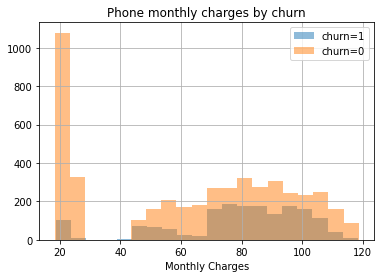

monthly charge for ex-customer count    1699.000000
mean       78.134255
std        22.567643
min        18.850000
25%        69.975000
50%        80.950000
75%        94.850000
max       118.350000
Name: MonthlyCharges, dtype: float64
-----------------------------------------------------------
monthly charge for current customer count    4653.000000
mean       63.261552
std        31.934310
min        18.250000
25%        24.500000
50%        69.900000
75%        90.050000
max       118.750000
Name: MonthlyCharges, dtype: float64


In [58]:
#since not all users have phone service, let's look at the ones with phone service

phone_id = client_data[client_data['customerID'].isin(phone['customerID'])]
phone_id[phone_id['churn']==1]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=1')
phone_id[phone_id['churn']==0]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=0')
plt.legend(loc='upper right')
plt.xlabel('Monthly Charges')
plt.title('Phone monthly charges by churn')
plt.show()

print('monthly charge for ex-customer',
      phone_id[phone_id['churn']==1]['MonthlyCharges'].describe())
print('-----------------------------------------------------------')
print('monthly charge for current customer',
      phone_id[phone_id['churn']==0]['MonthlyCharges'].describe())

We see a variation between the monthly charges for phone by churn. For customers that have left, the average monthly charge was 78, while the 25 percentile was 69. For customers that stayed, the average was 63, and the 25 percentile was 24. The upper percentile and max are relatively similar, suggesting that most customers that left on average paid a higher monthly charge for phone. 

### Monthly Charge for Internet

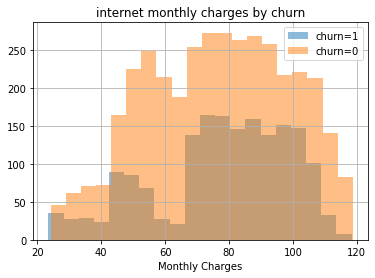

monthly charge for ex-customer count    1756.000000
mean       77.920985
std        21.144147
min        23.450000
25%        69.350000
50%        80.450000
75%        94.650000
max       118.350000
Name: MonthlyCharges, dtype: float64
-----------------------------------------------------------
monthly charge for current customer count    3756.000000
mean       76.356709
std        22.272199
min        24.150000
25%        59.137500
50%        78.725000
75%        94.312500
max       118.750000
Name: MonthlyCharges, dtype: float64


In [59]:
#since not all users have internet service, let's look at the ones with internet service

internet_id = client_data[client_data['customerID'].isin(internet['customerID'])]
internet_id[internet_id['churn']==1]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=1')
internet_id[internet_id['churn']==0]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=0')
plt.legend(loc='upper right')
plt.xlabel('Monthly Charges')
plt.title('internet monthly charges by churn')
plt.show()

print('monthly charge for ex-customer',
      internet_id[internet_id['churn']==1]['MonthlyCharges'].describe())
print('-----------------------------------------------------------')
print('monthly charge for current customer',
      internet_id[internet_id['churn']==0]['MonthlyCharges'].describe())

The difference in monthly charge for internet is not as variable as monthly charge for phone by churn. The average was 77 for ex-customer and 76 for current. Difference being 25 percentile, where ex-customer paid 69, while current customer paid 59. 

Overall, ex-customer tend to pay more for both internet and phone on a monthly basis. 

## Model Training

First we will drop our 'customerID' column because it will not be used as features. 

In [60]:
#drop customerID column

client_data = client_data.drop('customerID', axis = 1)

We will then split the data into training, and test sets in 3:1 ratio. We will need one dataset with One-Hot Encoding (OHE) and scaling, and one without encoding. We will perform upsampling with an upsampling function, due to class imbalance. 

### Upsampling 

In [61]:
#create a function for upsampling

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_ups = pd.concat([features_zeros] + [features_ones] * repeat)
    target_ups = pd.concat([target_zeros] + [target_ones] * repeat)
    features_ups, target_ups = shuffle(features_ups, target_ups, random_state=12345)
    return features_ups, target_ups

### One-Hot Encoding (OHE)

In [62]:
#perform ohe
client_data_ohe = pd.get_dummies(client_data, drop_first = True)

client_data_ohe.head()

,MonthlyCharges,TotalCharges,churn,totaldays,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,...,PaymentMethod_Mailed check,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
0,29.85,29.85,0,31.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,56.95,1889.50,0,1036.0,1,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
2,53.85,108.15,1,61.0,1,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
3,42.30,1840.75,0,1371.0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,1,0,0
4,70.70,151.65,1,61.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [63]:
#split the dataset after ohe

f_ohe = client_data_ohe.drop('churn', axis = 1)
t_ohe = client_data_ohe['churn']

f_ohe_train, f_ohe_test, t_ohe_train, t_ohe_test = train_test_split(f_ohe, t_ohe, test_size = 0.25, random_state = 12345)

print(f_ohe_train.shape, 
      f_ohe_test.shape, 
      t_ohe_train.shape, 
      t_ohe_test.shape)

(5274, 22) (1758, 22) (5274,) (1758,)


In [64]:
#upsample the training set

f_ohe_train, t_ohe_train = upsample(f_ohe_train, t_ohe_train, 3)
print(f_ohe_train.shape, 
      t_ohe_train.shape)

(8082, 22) (8082,)


In [65]:
#Scaling

numeric = ['MonthlyCharges', 'TotalCharges','totaldays']
scaler = StandardScaler()
scaler.fit(f_ohe_train[numeric])
f_ohe_train[numeric] = scaler.transform(f_ohe_train[numeric])
f_ohe_test[numeric] = scaler.transform(f_ohe_test[numeric])

f_ohe_train.head()

/tmp/ipykernel_42/4219941521.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_ohe_test[numeric] = scaler.transform(f_ohe_test[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,MonthlyCharges,TotalCharges,totaldays,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,...,PaymentMethod_Mailed check,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
1616,0.637200,0.452304,0.305534,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,1,0
5677,0.591817,-0.702195,-0.896508,1,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
6137,1.092781,0.150571,-0.108351,0,0,0,0,0,0,1,...,0,0,1,0,0,1,1,0,1,1
1681,-0.284435,-0.193608,-0.067372,0,0,1,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0
6142,0.097834,-0.624962,-0.774938,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Scaling without encoding

In [66]:
#split the data set

client_data_1 = client_data.copy()
f = client_data_1.drop('churn', axis = 1)
t = client_data_1['churn']

f_train, f_test, t_train, t_test = train_test_split(f, t, test_size = 0.25, random_state = 12345)

print(f_train.shape, 
      f_test.shape, 
      t_train.shape, 
      t_test.shape)

(5274, 18) (1758, 18) (5274,) (1758,)


In [67]:
#upsample

f_train, t_train = upsample(f_train, t_train, 3)
print(f_train.shape,
     t_train.shape)

(8082, 18) (8082,)


In [68]:
#scaling

numeric = ['MonthlyCharges', 'TotalCharges','totaldays']
scaler = StandardScaler()
scaler.fit(f_train[numeric])
f_train[numeric] = scaler.transform(f_train[numeric])
f_test[numeric] = scaler.transform(f_test[numeric])

f_train.head()

/tmp/ipykernel_42/1271328061.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_test[numeric] = scaler.transform(f_test[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,totaldays,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1616,Female,0,No,No,Month-to-month,Yes,Electronic check,0.637200,0.452304,0.305534,Yes,Fiber optic,No,No,No,No,Yes,No
5677,Male,1,No,No,Month-to-month,Yes,Bank transfer (automatic),0.591817,-0.702195,-0.896508,No,Fiber optic,Yes,No,No,No,Yes,No
6137,Female,0,No,No,Month-to-month,Yes,Electronic check,1.092781,0.150571,-0.108351,No,Fiber optic,No,Yes,Yes,No,Yes,Yes
1681,Female,0,Yes,Yes,Month-to-month,Yes,Electronic check,-0.284435,-0.193608,-0.067372,Yes,DSL,No,Yes,No,Yes,No,No
6142,Female,0,No,No,Month-to-month,No,Electronic check,0.097834,-0.624962,-0.774938,No,Fiber optic,No,No,No,No,No,No


### Logistic Regression

We will use cross-validation score on different models to determine the best model for our data set. 

In [69]:
#make a table for all of our cross-val scores

model_results = pd.DataFrame(columns = ('Model', 'Cross-val roc_auc score'))
model_results.head()

,Model,Cross-val roc_auc score


In [70]:
#LR

lr = LogisticRegression(solver = 'liblinear')
lr_score = cross_val_score(lr, f_ohe_train, t_ohe_train, scoring = 'roc_auc', cv = 5)

lr_data = ['LogisticRegression']
lr_data.append(lr_score.mean())
model_results.loc[len(model_results)] = lr_data
model_results.head()

,Model,Cross-val roc_auc score
0,LogisticRegression,0.844211


### Random Forest

In [71]:
#RF

for depth in range (20, 26):
    rf = RandomForestClassifier(n_estimators = 40, max_depth = depth, random_state = 12345)
    rf_score = cross_val_score(rf, f_ohe_train, t_ohe_train, scoring = 'roc_auc', cv = 5)
    print('Max_depth of', depth, 'score:', rf_score.mean())
    

Max_depth of 20 score: 0.9776877682871763
Max_depth of 21 score: 0.9781700948225028
Max_depth of 22 score: 0.9784966434508752
Max_depth of 23 score: 0.9779276846260739
Max_depth of 24 score: 0.9777353454316857
Max_depth of 25 score: 0.9781898349034643


In [72]:
rf = RandomForestClassifier(n_estimators = 40, max_depth = 22, random_state = 12345)
rf_score = cross_val_score(rf, f_ohe_train, t_ohe_train, scoring = 'roc_auc', cv = 5)
rf_data = ['Random Forest']
rf_data.append(rf_score.mean())
model_results.loc[len(model_results)] = rf_data
model_results.head()

,Model,Cross-val roc_auc score
0,LogisticRegression,0.844211
1,Random Forest,0.978497


### CatBoost

In [73]:
#catboost
cb = CatBoostClassifier(loss_function='Logloss',
                      learning_rate= 0.1,
                      random_seed=12345)
cb_score = cross_val_score(cb, f_ohe_train, t_ohe_train, scoring='roc_auc', cv=5)

0:	learn: 0.6482738	total: 3.7ms	remaining: 3.7s
1:	learn: 0.6149457	total: 7.23ms	remaining: 3.61s
2:	learn: 0.5866526	total: 12.3ms	remaining: 4.09s
3:	learn: 0.5625236	total: 16.1ms	remaining: 4s
4:	learn: 0.5457310	total: 19.4ms	remaining: 3.87s
5:	learn: 0.5298494	total: 22.8ms	remaining: 3.77s
6:	learn: 0.5185605	total: 27.5ms	remaining: 3.91s
7:	learn: 0.5054530	total: 31.5ms	remaining: 3.9s
8:	learn: 0.4987319	total: 34.9ms	remaining: 3.84s
9:	learn: 0.4923483	total: 40.4ms	remaining: 4s
10:	learn: 0.4846324	total: 43.4ms	remaining: 3.9s
11:	learn: 0.4779523	total: 46.7ms	remaining: 3.85s
12:	learn: 0.4737210	total: 50.5ms	remaining: 3.84s
13:	learn: 0.4702890	total: 53.9ms	remaining: 3.79s
14:	learn: 0.4662185	total: 57.2ms	remaining: 3.76s
15:	learn: 0.4623550	total: 60.5ms	remaining: 3.72s
16:	learn: 0.4599090	total: 63.8ms	remaining: 3.69s
17:	learn: 0.4567670	total: 67.2ms	remaining: 3.67s
18:	learn: 0.4532120	total: 70.4ms	remaining: 3.64s
19:	learn: 0.4516520	total: 73.7

In [74]:
cb_data = ['CatBoost']
cb_data.append(cb_score.mean())
model_results.loc[len(model_results)] =cb_data
model_results.head()

,Model,Cross-val roc_auc score
0,LogisticRegression,0.844211
1,Random Forest,0.978497
2,CatBoost,0.979504


### LightGBM


In [77]:
model_lgbm=LGBMClassifier()
parameters={'num_leaves': [10, 50],
           'learning_rate': [0.9, 0.1],
           'n_estimators': [10, 100],
           'random_state': [12345],
           'objective': ['binary']}
grid=GridSearchCV(estimator=model_lgbm, param_grid=parameters, scoring='roc_auc', cv=5, n_jobs=-1)
grid.fit(f_train, t_train)
best_param = grid.best_params_
best_score = grid.best_score_

lgbm_data = ['LightGBM']
lgbm_data.append(grid.best_score_)
model_results.loc[len(model_results)] =lgbm_data
model_results.head()

,Model,Cross-val roc_auc score
0,LogisticRegression,0.844211
1,Random Forest,0.978497
2,CatBoost,0.979504
3,LightGBM,0.980656
4,LightGBM,0.980656


We see that LightGBM showed the highest cross-validation roc_auc score, we will use this model for our final testing. 

### Final model fitting

In [78]:
#Final model with LightGBM

lgbm = LGBMClassifier(learning_rate = best_param['learning_rate'],
                      n_estimators = best_param['n_estimators'],
                      num_leaves = best_param['num_leaves'],
                      objective = 'binary', random_state = 12345)
lgbm.fit(f_train, t_train)
predict = lgbm.predict(f_test)
accuracy = accuracy_score(t_test, predict)
probability = lgbm.predict_proba(f_test)
auc_roc = roc_auc_score(t_test, probability[:,1])

print('AUC-ROC =', auc_roc)
print('Accuracy =', accuracy)

AUC-ROC = 0.8861337724222238
Accuracy = 0.8373151308304891


## Conclusion

By analyzing the datasets, we have found that clients that left typically paid a higer monthly charge on average. Moreover, some characterstics of clients that left are:
1. Used fibber optics for their internet service 
2. Not senior citizens
3. Do not have dependents
4. paying month to month
5. Enrolled in paperless billing & uses electronic check as payment method
6. Did not enroll in one or more of those internet services. 


We also cross-validate different models, based on their cross validation score, we chose LightGBM. After training, and test with the test set, we got a AUC-ROC score of ~.89, and accuracy score of ~0.84.

## Report
1. What steps of the plan were performed and what steps were skipped (explain why)?

I believed that I have performed all of the steps in the plan: Data Preprocessing, Data Analysis, Model Training and Conclusion

We converted necessary columns to their correct datatype. Created a new column for our target variables, and added a new feature column. We managed to merge the separate datasets into one where it will contain all of our feature columns and target column. 
EDA have been performed to check for features to determine if there are any outliers, null values, or class imbalance that might interfere with our model training.
After preprocessing and analysis. We built/trained our machine learning models. We encoded and scaled the data, and compare the metrics of sets after encoding to the one without encoiding/scaling. We will split the sample into training test set, with a 3:1 ratio. Tested different hyperparameters, use cross-validation to test. We selected our final model based on the cross validation scores and fit the test set.


2. What difficulties did you encounter and how did you manage to solve them?

I think the hardest part about this project was actually the EDA part, because there are so many ways of performing a EDA. And I am glad that I was able to make graphical representation of the analysis that I wished to perform by researching and learning new techniques. 

3. What were some of the key steps to solving the task?

Encoding, upsamplign and scaling the dataset, so basically all of the normalization/standardization steps. And remembering only fit the test set to the selected (best) model, not all models. 

4. What is your final model and what quality score does it have?

My final model was with LightGBM, and got a AUC-ROC score of ~.89, and accuracy score of ~0.84.